In [1]:
import math 
import torch
import matplotlib.pyplot as plt

In [2]:
#학습용 데이터
x = torch.linspace(-math.pi, math.pi, 1000)
#정답
y = torch.sin(x)

In [3]:
#3차 다항식
# f(x) = ax**3 + bx**2 +cx +d
#초기화
a,b,c,d =  torch.randn(()), torch.randn(()), torch.randn(()),torch.randn(())
y_random = a*x**3 + b*x**2+c*x+d

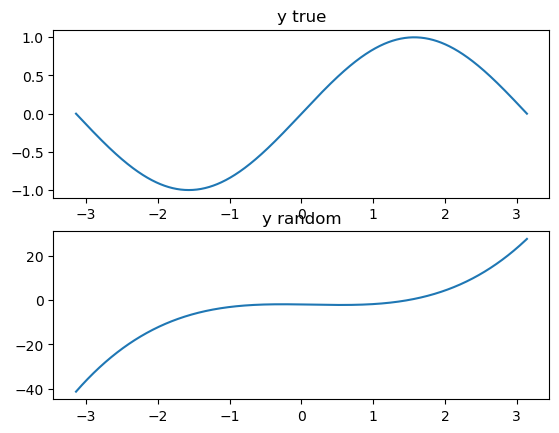

In [4]:
# 시각화
# 1. 실제값 시각화
plt.subplot(2,1,1)
plt.title('y true')
plt.plot(x,y)
#2. 임의의 가중치로 만든 예측용 값으로 시각화
plt.subplot(2,1,2)
plt.title('y random')
plt.plot(x,y_random)

plt.show()


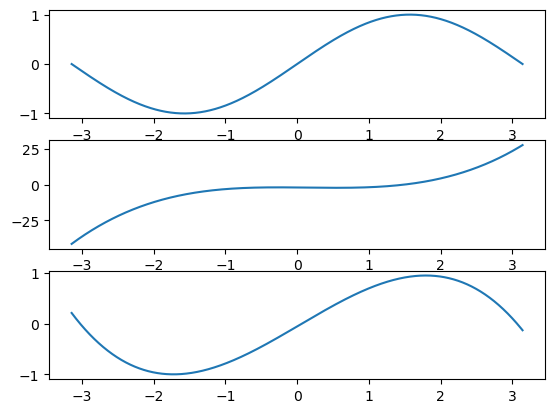

In [5]:
# 파라메터 정의
learning_rate = 1e-6
total_loss = []
for epoch in range(2000):
    # forward
    y_pred = a*x**3 + b*x**2 + c*x + d  # 모델
    # 손실 정의  MSE(평균제곱오차)  # 오차를 제곱 음수를 방지해서 크기만 보도록
    # 오차가 큰 값에 더 큰 패널티 부여
    loss = torch.sqrt((y_pred - y)**2).mean().item()  # 텐서에 저장된 숫자값만 추출 (그래프 추적을 피함)
    total_loss.append(loss)
    # 역전파 계산(BackPropagation) loss 줄이기 위해서  a,b,c,d 어느 방향으로 움직여야 할지 계산
    # 미분
    grad_y_pred = 2.0*(y_pred - y)  #기울기의 미분값
    grad_a = 2.0*(grad_y_pred*x**3).sum()
    grad_b = 2.0*(grad_y_pred*x**2).sum()
    grad_c = 2.0*(grad_y_pred*x).sum()
    grad_d = 2.0*(grad_y_pred).sum()
    # 가중치 업데이트
    a -= learning_rate * grad_a
    b -= learning_rate * grad_b
    c -= learning_rate * grad_c
    d -= learning_rate * grad_d

plt.subplot(3,1,1)
plt.plot(x,y)
plt.subplot(3,1,2)
plt.plot(x,y_random)
plt.subplot(3,1,3)
plt.plot(x, y_pred)

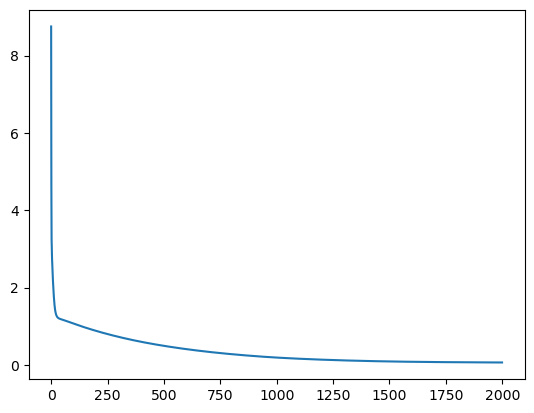

In [6]:
plt.plot(range(2000),total_loss)

D-loss / D-a
D-loss / D-b
D-loss / D-c
D-loss / D-d

loss는 파라메터들과 직접 연관이 없음
다만 다음과 같은 연쇄구조를 가진다(chain)

a,b,c,d -> y_pred -> loss
loss = (ypred-loss)

D-loss / D-a = D-ypred / D-a * D-loss /  D-ypred

 D-loss / D-ypred = 2x(ypred-y)

 D-ypred / D-a = x**3


In [7]:
# 보스턴 집값 예측
#  dataset = load_data
#  dataset
import pandas as pd
import numpy as np

data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

In [8]:

data.shape  ,  target.reshape(-1,1).shape

((506, 13), (506, 1))

In [9]:
# pytorch
# 미분을 자동으로 계산
# 계산된 미분을 optimizer를 통해 적용: 최적화 알고리즘
import torch
import torch.nn as nn
from torch.optim.adam import Adam
#모델 정의
model = nn.Sequential(
    nn.Linear(data.shape[1],100), #13의 데이터를 입력받아서 결과를 100개 즉 100개를 예측
    nn.ReLU(), #활성함수
    nn.Linear(100, 1) #100개의 예측 결과를 받아서 최종 1개를 예측
)

#하이퍼파라메터 정의
batch_size = 100 #100번 돌게 
learning_rate = 1e-03 #0.001

#옵티마이저 정의
optim = Adam(model.parameters(), lr=learning_rate)

target = target.reshape(-1,1)
#학습루프
for epoch in range(200):
    for i in range(len(data) // batch_size):
        start = i*batch_size
        end = start + batch_size
        X = torch.FloatTensor(data[start:end])
        y = torch.FloatTensor(target[start:end]).view(-1, 1)

        optim.zero_grad() #학습 이후 다음 학습에 이전 가중치가 계산되는 것을 방지
        preds = model(X) # preds과 정답의 shape 값아야함
        loss = nn.MSELoss()(preds,y) #__call__자동...
        loss.backward() #기울기 계산 
        optim.step() #업데이트 옵티마이저가 .grad정보를 사용해서 파라메터를 갱신
    if epoch % 20 ==0:
        print(f'epoch : {epoch +1} : loss : {loss.item()}') #epoch의 가장 마지막 배치만 출력(평균)

epoch : 1 : loss : 465.5221862792969
epoch : 21 : loss : 22.101938247680664
epoch : 41 : loss : 18.688203811645508
epoch : 61 : loss : 16.9290828704834
epoch : 81 : loss : 15.567083358764648
epoch : 101 : loss : 14.616665840148926
epoch : 121 : loss : 14.129654884338379
epoch : 141 : loss : 13.743073463439941
epoch : 161 : loss : 13.503752708435059
epoch : 181 : loss : 13.35559368133545


```
순전파 : X-> model-> preds -> loss
역전파 : dloss / dpreds #계산해서 각 선형층의 파라메터(가중치,편향)로 전파
loss.backward() 호출되어서 pytorch autograd가 연쇄법칙(chain rule)을 이용해서 각 파라메터의 .grad를 채움
optim.step() : .grad를 읽어서 파라메터를 갱신

ReLU(활성화 함수) : max(0,z)
z가 음수이면 0, 양수면 그대로 전달
역전파
    z >0 dReLU(z)/dz = 1
    z <=0 dReLU(z)/dz = 0
    비선형을 제공해서 계산이 간단해진다
    기울기 소실이 sigmoid, tanh(하이퍼블릭탄젠트)보다 유리
    음수이면 0이니깐.. 일부 누련이 비활화되어 표현이 희소해진다. ->LeekyReLU 층이 깊을때 층이 안깊으면 sigmoid로 충분

Adam: 옵티마이저
    모멘텀 과 스케일 조정 두가지 방법을 결합
    적응적 학습률 : 파라메터별로 학습률을 조정 -> 초기값 안정적 
    빠른 수렴 : SGD보다 빠름
    튜닝이 거의 필요없음... 기본 파라메터가 lr = 0.001 도 좋은 성능
    단점 : 과적합이 다른 최적화 모델에 비해 발생하기 쉬운 구조
```

```
옵티마이저 : 모델 파라메터를 손실이 줄어들게 갱신하는 역할
p_t : 현재 라메터
n : 학습률
gt :현재 그레이디언트

p_t+1 =  p_t-n*gt
단점 :
    기울기가 들쑥날쑥( 노이즈에 약함)
    모든 파라메터가 같은 학습률에 적용(비효율적)
    --> 모멘텀, 스케일 조정

모멘텀 Momentum
    이전 단계의 이동방향을 "기억"해서 관성처럼 부드럽게 이동하는 기법
    vi : 누적된 속도 또는 1차 모멘트
    gt : 현재 그레이디언트 
    b1 : 모멘텀의 갯수(보통0.9)
    n : 학습률
    vt = b1vt-1 +(1-b1)gt
        pt+1 = pt - n*vt
시점    
    t : 1       단순히 g1dmf Ekfkrka
    t : 2       이전 속도 v1의 일부를 남겨서 새로운 방향에 더해
    t -> inif 여러 스탭동안 방향이 일정하면 점점 가속되어 빠르게 수렴
    기울기가 변해도 관성때문에 부드럽게ㅜ 움직임

스케일 조정
    파라메터의 기울기의 크기를 고려해서 학습률을 자동으로 조정
    과거 파라메터의 크기를 추적해서 큰 변동이 있었던 파라메터는 작게, 작은 변동은 크게 이동

아담 : 모멘텀 + 스케일 조정 하이브리드 방식
    step1 : 모멘텀
    step2 : 스케일 조정
    step3 : 바이서 보정 초기 스텝에서는 m, v = 0보정
    step4 : 최종업데이트: 모멘텀으로 얻은 방향 + 스케일 조정된 학습률 이동

SGD                 단순히 그레이디언트                         진동심함, 느림
Momentum            과거 방향의 관성 사용                       진동완화, 빠른수렴
RMSProp / AdaGrad   그레이디언트 제곱의 평균으로 스케일 조정    파라메터별 자동 학습률
Adam                모멘텀+RMSProm 결합                         기본설정도 훌륭함
```


In [10]:
# 모델 성능 평가 : 예측
print(data.shape, target.shape)
predict = model(torch.FloatTensor(data)).detach().numpy()
predict.shape, target.shape

(506, 13) (506, 1)


((506, 1), (506, 1))

In [11]:
from sklearn.metrics import r2_score
r2_score(target,predict)

0.6230592384965529

In [15]:
#적절한 머신러닝 알고리즘으로 비교평가
#linear 모델 학습
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import numpy as np
from sklearn.linear_model import LinearRegression

# X, y 준비 (스케일러가 numpy 배열을 받으니 numpy 유지)
X = data.astype(np.float32)         # (506, 13)
y = target.astype(np.float32)       # (506,)

# 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
# 모델학습
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
r2 = r2_score(y_test, y_pred)

print("R2 score :", r2)

R2 score : 0.6687601804733276


In [ ]:
#randomforest로 회귀
from sklearn.ensemble import RandomForestRegressor
